In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
# red image on the left
# cyan image on the right


[[ 94 109 159 ...  98  97  96]
 [143 161 191 ...  97  96  95]
 [197 176 178 ...  97  96  95]
 ...
 [ 45  69  74 ...  59  65  72]
 [ 39  91 175 ...  53  60  67]
 [ 33  73 146 ...  53  56  59]]
300
302


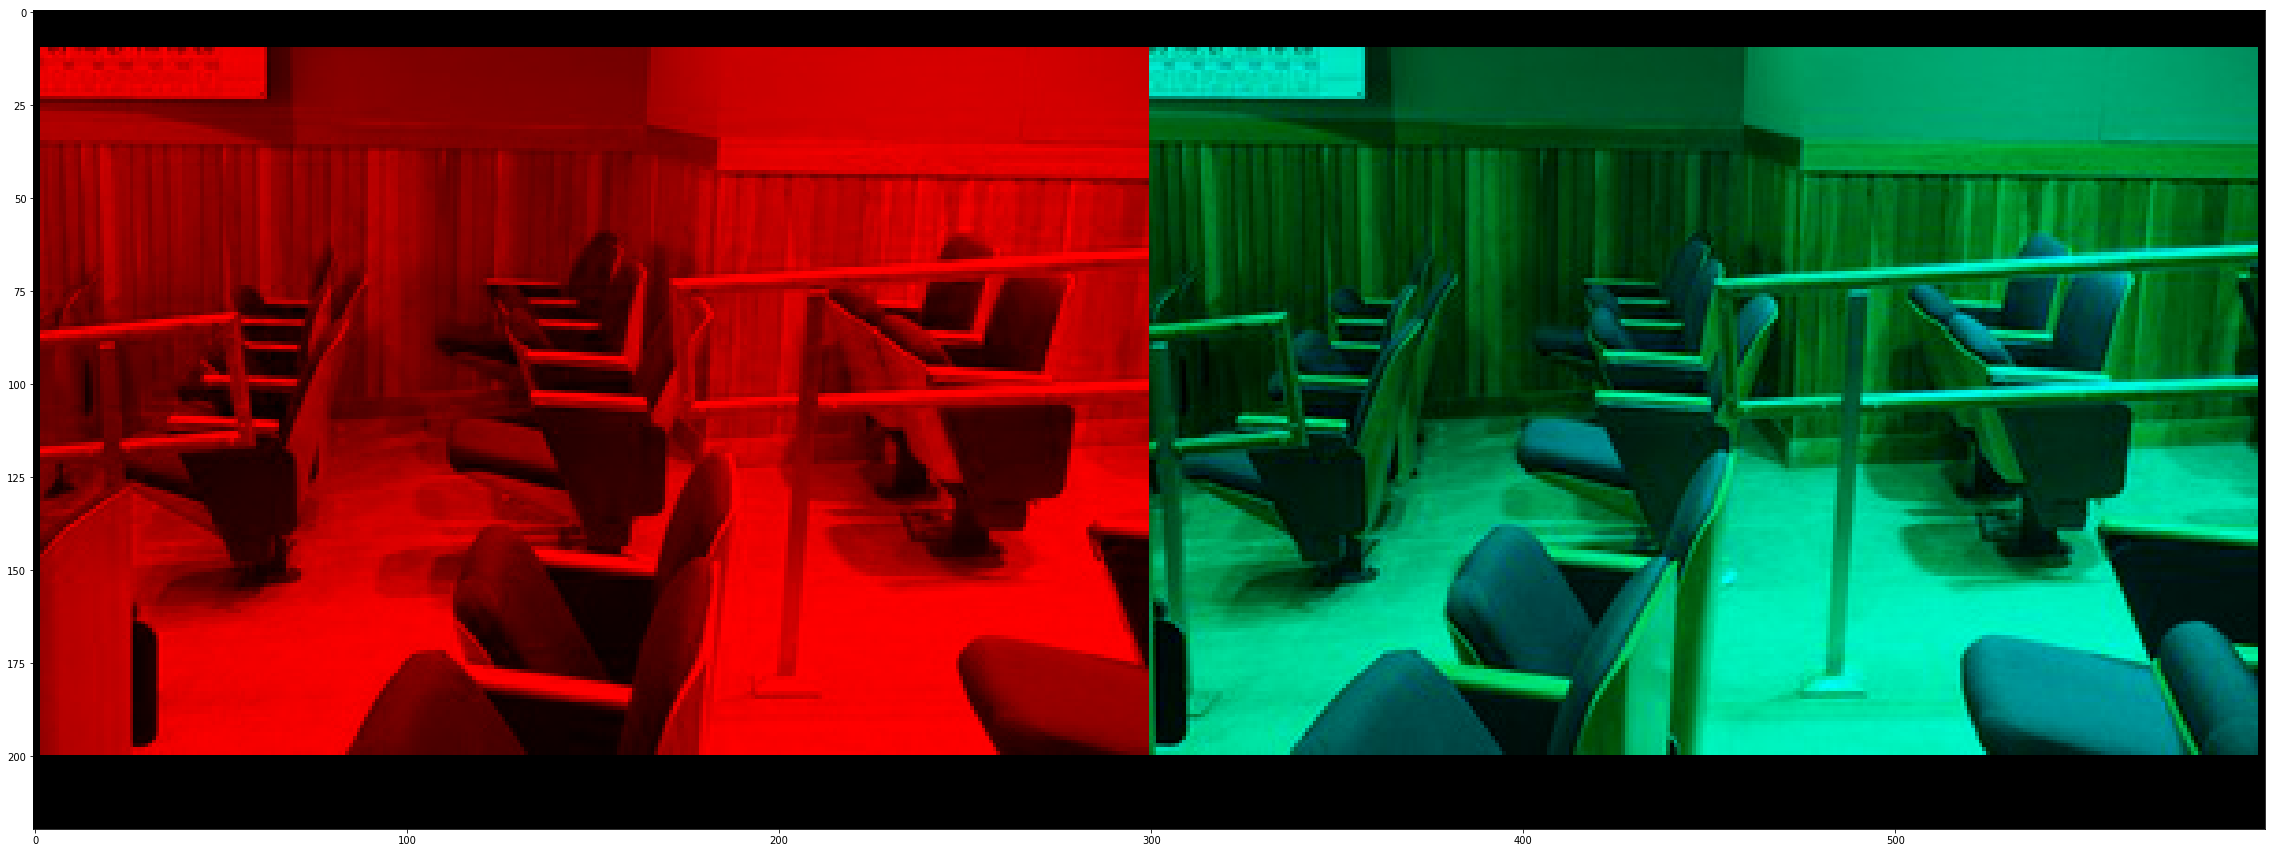

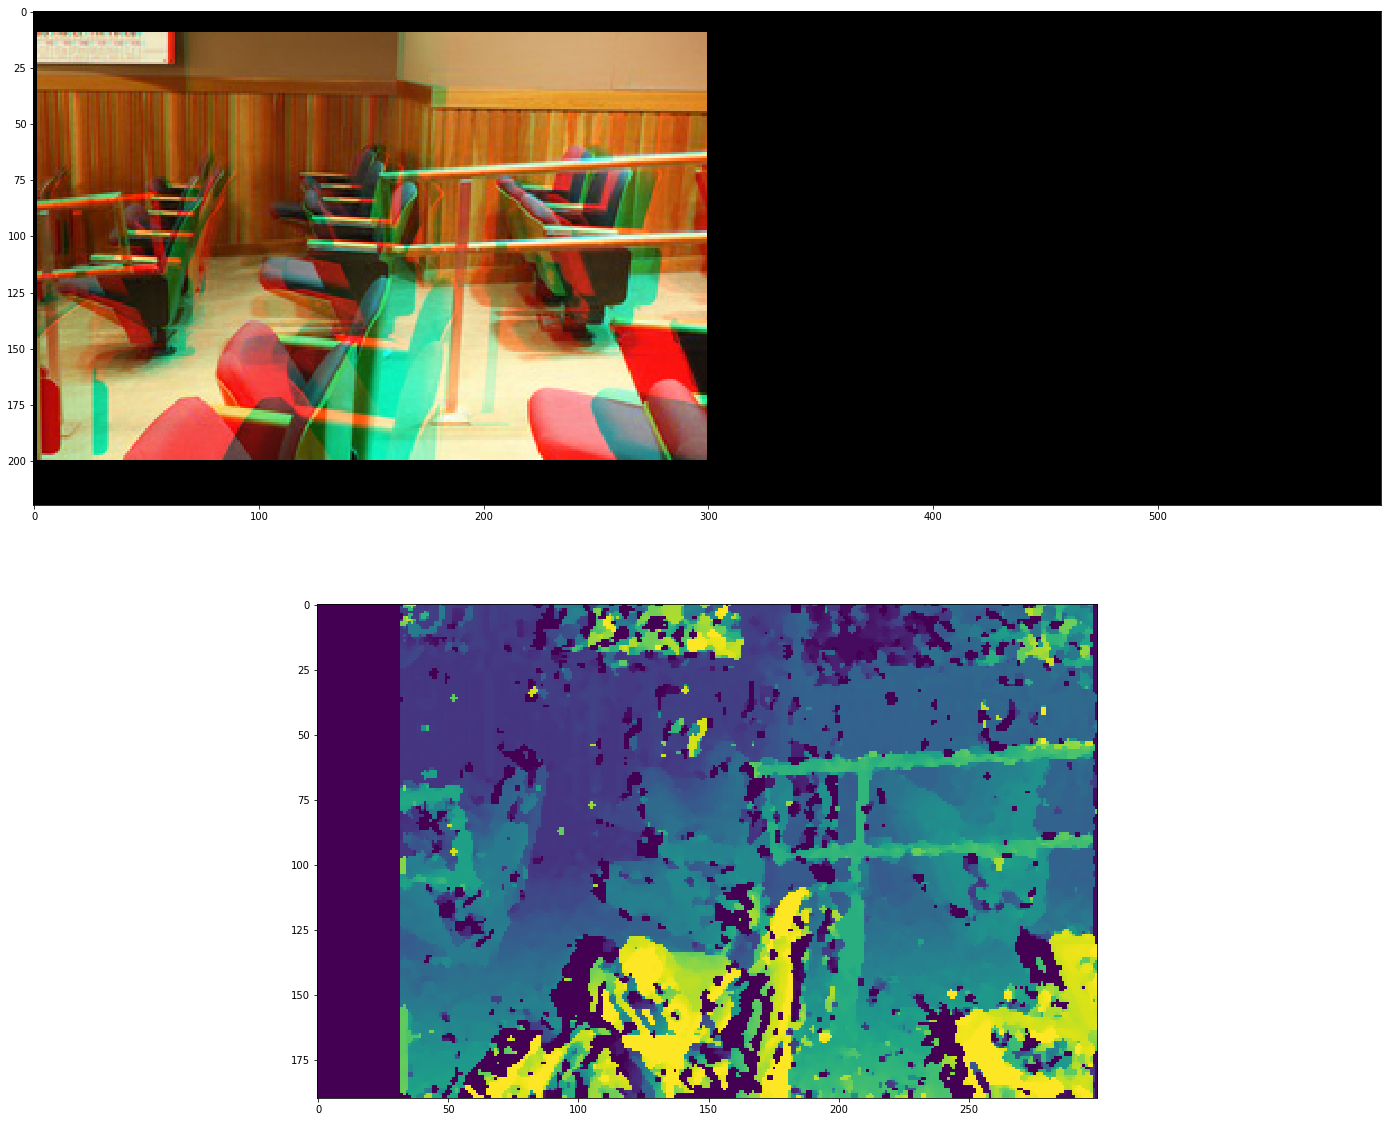

In [78]:
image0 = cv2.imread("images/classroom/im0.jpg")
image1 = cv2.imread("images/classroom/im1.jpg")


class Stereo:
    def __init__(self):
        pass
    
    def compute(self, images, numDisparities=16, blockSize=15):
        (left, right) = images
        left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
        right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
        stereo = cv2.StereoSGBM_create(numDisparities=numDisparities)
        #stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)
        disparity = stereo.compute(left, right)
        
        return disparity

class Stitcher:
    def __init__(self):
        pass
    
    def pointTest(self, points):
        top_left = [75,100]
        bottom_right = [200,0]
        result = []
        
        for point in points:
            x,y = point
            if x >= top_left[0] and x <= bottom_right[0] and y <= top_left[1] and y >= bottom_right[1]:
                result.append([x, y])
        return np.array(result)
    
    def removeOverlap(self):
        pass
        
    def detectAndDescribe(self, image, mask=None):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
#         mask = np.zeros(image.shape, dtype=np.uint8)
        (kps, features) = sift.detectAndCompute(image, mask)
        
        kps = np.float32([kp.pt for kp in kps])
       
        return (kps, features)
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThres):
        bf = cv2.BFMatcher(crossCheck=True)
        matches = bf.match(featuresA, featuresB)
        
        if len(matches) > 4:
            ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
            ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
#           ptsA = np.float32([kpsA[i] for (_, i) in matches])
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThres)
            # return the matches along with the homography matrix
            # and status of each matched point
            return (matches, H, status)
        
        # otherwise, no homography could be computer
        return None
    
    def stitch(self, images, points, ratio=0.75, reprojThres=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageA, imageB) = images
        (top_left, bottom_right) = points
        
        #create mask
        (rows, cols, _) = imageA.shape
        mask = np.ones((rows, cols), dtype=np.uint8)
        mask[bottom_right[1]:top_left[1], top_left[0]:bottom_right[0]] = 0
        
        (kpsA, featuresA) = self.detectAndDescribe(imageA, mask)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThres)
        
        if M is None:
            return None
        
#         (matches, H, status) = M
        # otherwise, apply a perspective warp to stitch the images
        # together
        
        #[[ 0.98609989  0.00706807 -7.03132545]
        #[-0.01265045  1.06768518 -0.94108555]
        #[ 0.          0.          1.        ]]
        (matches, H, status) = M
        # only use rotation and translation of H
        H[2] = [0, 0, 1]
        #we really only care about x and y
        x_offset = math.floor(math.fabs(H[0,2])) + 1
        y_offset = math.floor(math.fabs(H[1,2])) + 1
        (_,_, r) = cv2.split(imageA)
        r[:, 0:x_offset] = 0
        (b,g,_) = cv2.split(imageB)
        print(b[:,0:-9])
        b[:, imageB.shape[1] - x_offset :imageB.shape[1]] = 0
        g[:, imageB.shape[1]- x_offset :imageB.shape[1]] = 0
        print(imageB.shape[1])
        print(imageB.shape[1] + x_offset)
        imageA_corrected = cv2.merge([r, g, b])
       
        result = np.zeros((imageA.shape[0] + 30, 2 * imageA.shape[1], 3), dtype=np.int)
        result2 = np.copy(result)
        result[10:imageA.shape[0] + 10, 0:imageA.shape[1], 0] = r
        result[10:imageA.shape[0] + 10, imageB.shape[1]:imageB.shape[1]+imageB.shape[1], 1] = g
        result[10:imageA.shape[0] + 10, imageB.shape[1]:imageB.shape[1]+imageB.shape[1], 2] = b
        
        
        result2[10:imageA.shape[0] + 10, 0:imageA.shape[1], 0] = r
        result2[10:imageA.shape[0] + 10, 0 + x_offset:imageB.shape[1] + x_offset, 1] = g
        result2[10:imageA.shape[0] + 10, 0 + x_offset:imageB.shape[1] + x_offset, 2] = b
        
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            
            # return a tuple of the stitched image and the
            # visualiaztion
            return (result, vis)
        return result, result2
    
stitcher = Stitcher()
stereo = Stereo()
top_left = [75,100]
bottom_right = [200,0]
(result, result2) = stitcher.stitch([image0, image1], [top_left, bottom_right])
stereo_result = stereo.compute([image0, image1], numDisparities=32, blockSize=15)
plt.figure(figsize=(40,20))
plt.imshow(result)
fig, ax = plt.subplots(2)
fig.set_size_inches(40,20)
ax[0].imshow(result2)
ax[1].imshow(stereo_result)

    

        